In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_EDA import *

plt.rcParams["figure.figsize"] = (14,4)

In [2]:
import serial
import re

# 시리얼 포트 설정
port = '/dev/ttyACM0'  # 사용할 COM 포트 번호
baudrate = 460800  # 장치와 일치하는 전송 속도
timeout = 2  # 타임아웃 설정 (2초)

def find_different(data):
    if len(background) == 0:
        background.append(data)
    elif len(background) < 20:
        background.append(data)
        now_background = np.median(background, axis=0)
        # pd.DataFrame(now_background).plot()
        # plt.show()
        subtrack = np.abs(data - now_background)
        return subtrack
    else:
        background.pop(0)
        background.append(data)
        now_background = np.median(background, axis=0)
        # pd.DataFrame(now_background).plot()
        # plt.show()
        subtrack = np.abs(data - now_background)
        return subtrack

def same_peak_flatten(data):
    peak = np.argmax(data)
    return data.iloc[peak-10:peak+150].reset_index(drop=True, inplace=False)

def clean_data(raw_data):
    """
    수신된 원시 데이터를 정제하여 숫자 값 리스트로 반환합니다.
    """
    cleaned_data = []
    for item in raw_data:
        # 문자열 내의 숫자 패턴 찾기
        match = re.search(r'\d+\.\d+|\d+', item)
        if match:
            cleaned_data.append(float(match.group()))
    return cleaned_data

try:
    # 시리얼 포트 열기
    ser = serial.Serial(port, baudrate, timeout=timeout)

    print(f"Connected to {port} at {baudrate} baudrate.")
    data_buffer = ""  # 수신 데이터를 임시 저장할 버퍼
    temp_list = []  # 임시 리스트
    final_list = []  # 최종 cir 리스트
    final_distance = []  # 최종 거리값 리스트
    diff_list = []  # 차이값 리스트
    background = []
    now_background = []

    while True:
        # 시리얼 포트로부터 데이터 읽기
        if ser.in_waiting > 0:  # 읽을 데이터가 있는 경우
            data = ser.read(ser.in_waiting).decode('utf-8', errors='ignore')  # 모든 가용 데이터를 읽어옴
            data_buffer += data  # 수신 데이터를 버퍼에 추가

            # 버퍼 내의 데이터에서 완성된 부분을 처리
            if ',' in data_buffer:
                # 데이터를 콤마를 기준으로 분할
                split_data = data_buffer.split(',')
                # 마지막 요소는 아직 완성되지 않은 데이터일 수 있으므로 버퍼에 남김
                data_buffer = split_data[-1]
                # 완성된 데이터들만 임시 리스트에 추가
                temp_list.extend([value.strip() for value in split_data[:-1]])

            # "DIST" 문자열을 만났는지 확인
            if "D" in data_buffer:
                # "DIST" 문자열을 만나면 임시 리스트를 최종 리스트에 추가
                cleaned_temp_list = clean_data(temp_list)  # 데이터 정제
                if len(cleaned_temp_list) % 992 == 0:
                    for i in range(0, len(cleaned_temp_list), 992):
                        final_list.append(cleaned_temp_list[i+1:i + 992])
                        final_distance.append(cleaned_temp_list[i])
                        clean_temp_list_df = pd.DataFrame(cleaned_temp_list[i+1:i+992])
                        same_peak_data = same_peak_flatten(clean_temp_list_df)
                        diff = find_different(same_peak_data)
                        if diff is not None:
                            diff_list.append(diff.values.flatten())
                            print(f"Distance: {final_distance[-1]:.2f} | Peak: {np.argmax(diff) - 10:3d} | Maximum Difference: {diff.iloc[np.argmax(diff)].values[0]:5.0f}")
                            # print(f"Distance: {cleaned_temp_list[i]}", end=' ')
                            # print(f"Peak: {np.argmax(diff)-10}", end=' ')
                            # print(f"Maxmuim difference: {round(diff.iloc[np.argmax(diff)].values[0])}")
                else:
                    if len(cleaned_temp_list) > 992:
                        for i in range(0, len(cleaned_temp_list) - (len(cleaned_temp_list) % 992), 992):
                            final_list.append(cleaned_temp_list[i+1:i+992])
                            final_distance.append(cleaned_temp_list[i])
                            clean_temp_list_df = pd.DataFrame(cleaned_temp_list[i+1:i+992])
                            same_peak_data = same_peak_flatten(clean_temp_list_df)
                            diff = find_different(same_peak_data)
                            if diff is not None:
                                diff_list.append(diff.values.flatten())
                                print(f"Distance: {final_distance[-1]:.2f} | Peak: {np.argmax(diff) - 10:3d} | Maximum Difference: {diff.iloc[np.argmax(diff)].values[0]:5.0f}")
                                # print(f"Distance: {cleaned_temp_list[i]}", end=' ')
                                # print(f"Peak: {np.argmax(diff)-10}", end=' ')
                                # print(f"Maxmuim difference: {round(diff.iloc[np.argmax(diff)].values[0])}")
                    # 임시 리스트 초기화
                temp_list = []

except serial.SerialException as e:
    print(f"Error opening or using serial port: {e}")

except KeyboardInterrupt:
    print("\nExiting program.")

finally:
    final_list = pd.DataFrame(final_list)
    final_distance = pd.DataFrame(final_distance)
    diff_list = pd.DataFrame(diff_list)
    if 'ser' in locals() and ser.is_open:
        ser.close()  # 프로그램 종료 시 시리얼 포트 닫기
        print("Serial port closed.")


Connected to /dev/ttyACM0 at 460800 baudrate.
Distance: 0.45 | Peak:   1 | Maximum Difference:  1011
Distance: 0.44 | Peak:   2 | Maximum Difference:   223
Distance: 0.41 | Peak:  -1 | Maximum Difference:   400
Distance: 0.42 | Peak:  -1 | Maximum Difference:   253
Distance: 0.46 | Peak:   2 | Maximum Difference:  1110
Distance: 0.44 | Peak:   2 | Maximum Difference:  1647
Distance: 0.41 | Peak:   1 | Maximum Difference:  2888
Distance: 0.42 | Peak:   2 | Maximum Difference:  2595
Distance: 0.40 | Peak:   2 | Maximum Difference:   598
Distance: 0.42 | Peak:  -1 | Maximum Difference:   169
Distance: 0.44 | Peak:   2 | Maximum Difference:   378
Distance: 0.42 | Peak:  -1 | Maximum Difference:  2424
Distance: 0.43 | Peak:   2 | Maximum Difference:   318
Distance: 0.45 | Peak:   1 | Maximum Difference:  2356
Distance: 0.44 | Peak:   1 | Maximum Difference:   616
Distance: 0.40 | Peak:   1 | Maximum Difference:  2636
Distance: 0.44 | Peak:   2 | Maximum Difference:   216
Distance: 0.45 | Pe

In [3]:
print(final_list.shape)
print(final_distance.shape)
same_final = same_peak(final_list)
same_final.shape

(26, 991)
(26, 1)


(26, 160)

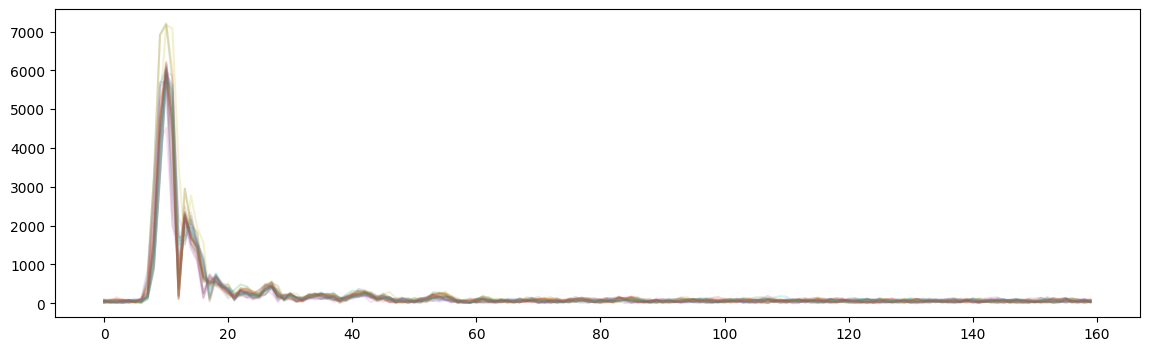

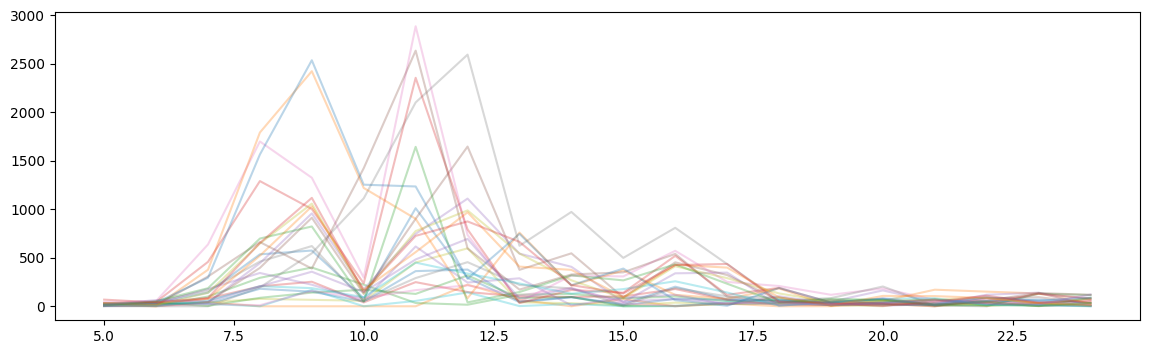

In [4]:
for i in range(len(same_final)):
    same_final.loc[i].plot(alpha=0.2)
plt.show()
for i in range(len(diff_list)):
    diff_list.loc[i][5:25].plot(alpha=0.3)
plt.show()

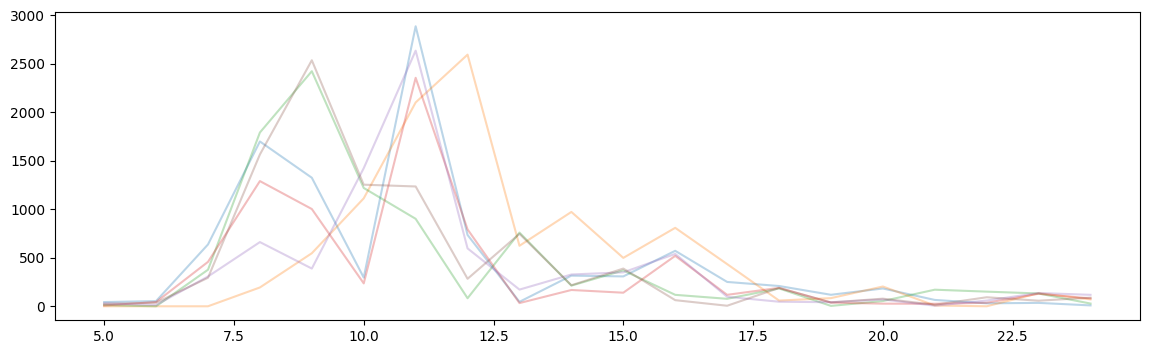

In [5]:
for i in range(len(diff_list)):
    if diff_list.iloc[i][np.argmax(diff_list.iloc[i])] > 2000:   # threshold가 2000은 되어야 변화가 일어난 것일듯?
        diff_list.iloc[i][5:25].plot(alpha=0.3)

<Axes: >

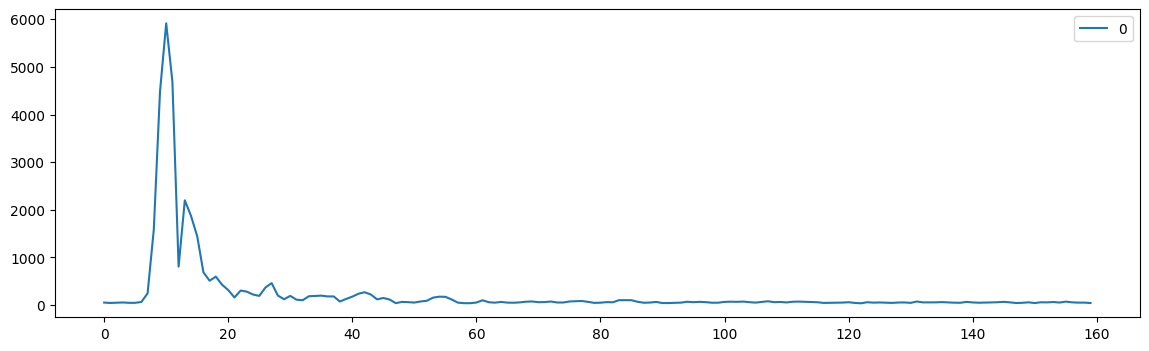

In [6]:
pd.DataFrame(np.median(background, axis=0)).plot()  

In [ ]:
import serial
import re

# 시리얼 포트 설정
port = '/dev/ttyACM0'  # 사용할 COM 포트 번호
baudrate = 460800  # 장치와 일치하는 전송 속도
timeout = 2  # 타임아웃 설정 (2초)

def find_different(data):
    if len(background) == 0:
        background.append(data)
    elif len(background) < 20:
        background.append(data)
        now_background = np.mean(background, axis=0)
        subtrack = np.abs(data - now_background)
        return subtrack
    else:
        background.pop(0)
        background.append(data)
        now_background = np.mean(background, axis=0)
        subtrack = np.abs(data - now_background)
        return subtrack
    
def regularize(data):
    """
    데이터 정규화 함수
    """
    return (data - data.min()) / (data.max() - data.min())

def same_peak_flatten(data):
    peak = np.argmax(data)
    return data.iloc[peak-10:peak+150].reset_index(drop=True, inplace=False)

def clean_data(raw_data):
    """
    수신된 원시 데이터를 정제하여 숫자 값 리스트로 반환합니다.
    """
    cleaned_data = []
    for item in raw_data:
        # 문자열 내의 숫자 패턴 찾기
        match = re.search(r'\d+\.\d+|\d+', item)
        if match:
            cleaned_data.append(float(match.group()))
    return cleaned_data

try:
    # 시리얼 포트 열기
    ser = serial.Serial(port, baudrate, timeout=timeout)

    print(f"Connected to {port} at {baudrate} baudrate.")
    data_buffer = ""  # 수신 데이터를 임시 저장할 버퍼
    temp_list = []  # 임시 리스트
    final_list = []  # 최종 cir 리스트
    final_distance = []  # 최종 거리값 리스트
    diff_list = []  # 차이값 리스트
    background = []
    now_background = []

    while True:
        # 시리얼 포트로부터 데이터 읽기
        if ser.in_waiting > 0:  # 읽을 데이터가 있는 경우
            data = ser.read(ser.in_waiting).decode('utf-8', errors='ignore')  # 모든 가용 데이터를 읽어옴
            data_buffer += data  # 수신 데이터를 버퍼에 추가

            # 버퍼 내의 데이터에서 완성된 부분을 처리
            if ',' in data_buffer:
                # 데이터를 콤마를 기준으로 분할
                split_data = data_buffer.split(',')
                # 마지막 요소는 아직 완성되지 않은 데이터일 수 있으므로 버퍼에 남김
                data_buffer = split_data[-1]
                # 완성된 데이터들만 임시 리스트에 추가
                temp_list.extend([value.strip() for value in split_data[:-1]])

            # "DIST" 문자열을 만났는지 확인
            if "D" in data_buffer:
                # "DIST" 문자열을 만나면 임시 리스트를 최종 리스트에 추가
                cleaned_temp_list = clean_data(temp_list)  # 데이터 정제
                if len(cleaned_temp_list) % 992 == 0:
                    for i in range(0, len(cleaned_temp_list), 992):
                        final_list.append(cleaned_temp_list[i+1:i + 992])
                        final_distance.append(cleaned_temp_list[i])
                        clean_temp_list_df = pd.DataFrame(cleaned_temp_list[i+1:i+992])
                        same_peak_data = same_peak_flatten(clean_temp_list_df)
                        regular_data = regularize(same_peak_data)
                        diff = find_different(regular_data)
                        if diff is not None:
                            diff_list.append(diff.values.flatten())
                            print(f"Distance: {final_distance[-1]:.2f} | Peak: {np.argmax(diff) - 10:3d} | Maximum Difference: {diff.iloc[np.argmax(diff)].values[0]:5.3f}")

                else:
                    if len(cleaned_temp_list) > 992:
                        for i in range(0, len(cleaned_temp_list) - (len(cleaned_temp_list) % 992), 992):
                            final_list.append(cleaned_temp_list[i+1:i+992])
                            final_distance.append(cleaned_temp_list[i])
                            clean_temp_list_df = pd.DataFrame(cleaned_temp_list[i+1:i+992])
                            same_peak_data = same_peak_flatten(clean_temp_list_df)
                            regular_data = regularize(same_peak_data)
                            diff = find_different(regular_data)
                            if diff is not None:
                                diff_list.append(diff.values.flatten())
                                print(f"Distance: {final_distance[-1]:.2f} | Peak: {np.argmax(diff) - 10:3d} | Maximum Difference: {diff.iloc[np.argmax(diff)].values[0]:5.0f}")

                    # 임시 리스트 초기화
                temp_list = []

except serial.SerialException as e:
    print(f"Error opening or using serial port: {e}")

except KeyboardInterrupt:
    print("\nExiting program.")

finally:
    final_list = pd.DataFrame(final_list)
    final_distance = pd.DataFrame(final_distance)
    diff_list = pd.DataFrame(diff_list)
    if 'ser' in locals() and ser.is_open:
        ser.close()  # 프로그램 종료 시 시리얼 포트 닫기
        print("Serial port closed.")

Connected to /dev/ttyACM0 at 460800 baudrate.
Distance: 0.39 | Peak:  -2 | Maximum Difference: 0.228
Distance: 0.44 | Peak:  -2 | Maximum Difference: 0.114
Distance: 0.45 | Peak:   1 | Maximum Difference: 0.177
Distance: 0.38 | Peak:   1 | Maximum Difference: 0.256
Distance: 0.38 | Peak:   1 | Maximum Difference: 0.276
Distance: 0.44 | Peak:   1 | Maximum Difference: 0.134
Distance: 0.41 | Peak:   1 | Maximum Difference: 0.288
Distance: 0.45 | Peak:   1 | Maximum Difference: 0.226
Distance: 0.40 | Peak:   1 | Maximum Difference: 0.228
Distance: 0.44 | Peak:   1 | Maximum Difference: 0.333
Distance: 0.40 | Peak:   1 | Maximum Difference: 0.289
Distance: 0.43 | Peak:   1 | Maximum Difference: 0.159
Distance: 0.44 | Peak:   2 | Maximum Difference: 0.184
Distance: 0.44 | Peak:   2 | Maximum Difference: 0.177
Distance: 0.42 | Peak:   1 | Maximum Difference: 0.220
Distance: 0.45 | Peak:   1 | Maximum Difference: 0.111
Distance: 0.45 | Peak:  -1 | Maximum Difference: 0.213
Distance: 0.45 | Pe

(80, 991)
(80, 1)


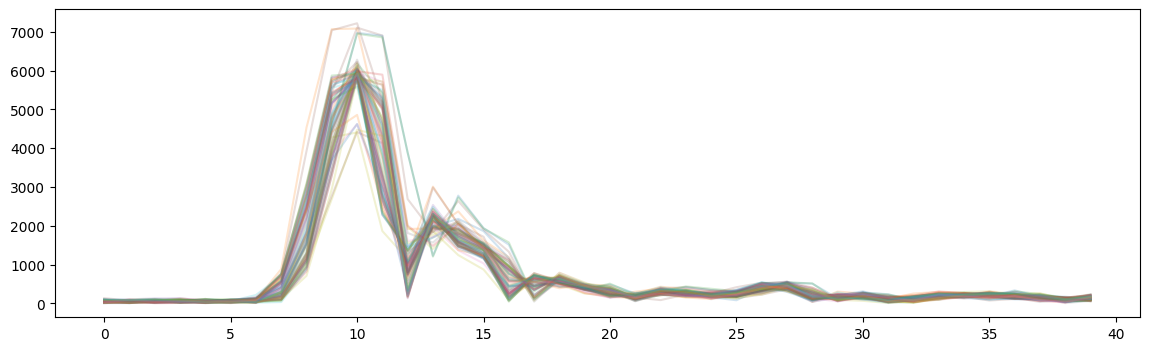

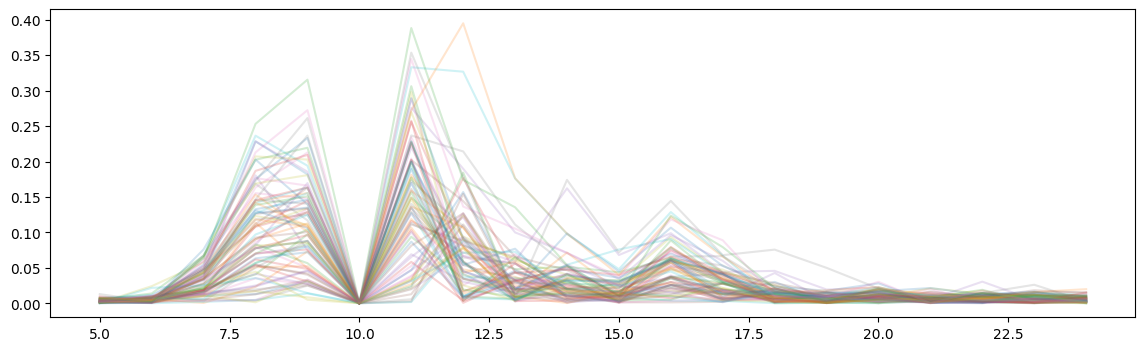

6


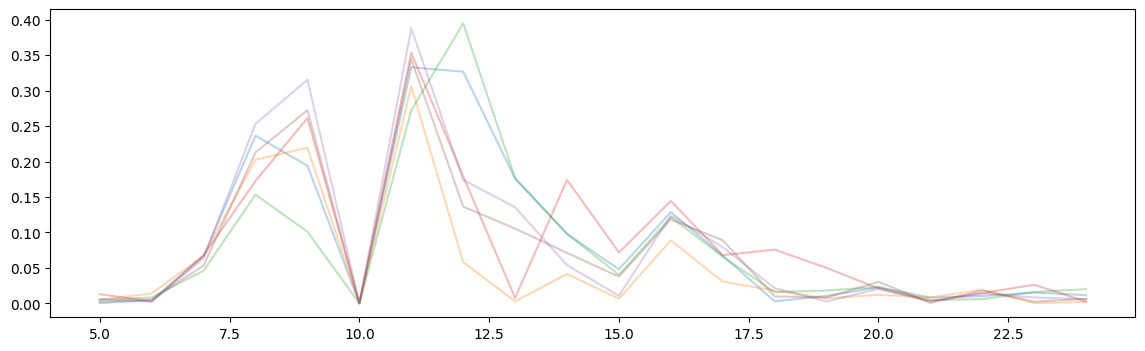

In [8]:
print(final_list.shape)
print(final_distance.shape)
same_final = same_peak(final_list)
same_final.shape

for i in range(len(same_final)):
    same_final.loc[i][:40].plot(alpha=0.2)
plt.show()
for i in range(len(diff_list)):
    diff_list.loc[i][5:25].plot(alpha=0.2)
plt.show()

count = 0
for i in range(len(diff_list)):
    if diff_list.iloc[i][np.argmax(diff_list.iloc[i])] > 0.3:   # threshold가 2000은 되어야 변화가 일어난 것일듯?
        diff_list.iloc[i][5:25].plot(alpha=0.3)
        count += 1
print(count)


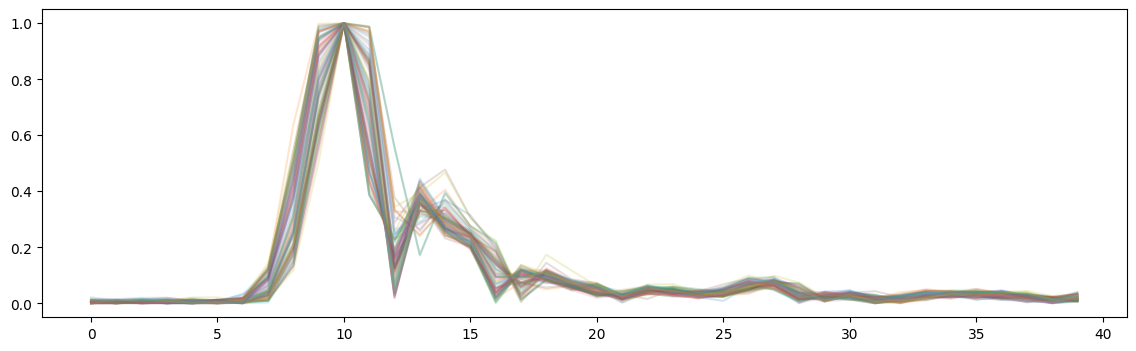

In [12]:
# final_list 정규화
for i in range(len(same_final)):
    regularize(same_final.loc[i][:40]).plot(alpha=0.2)

<Axes: >

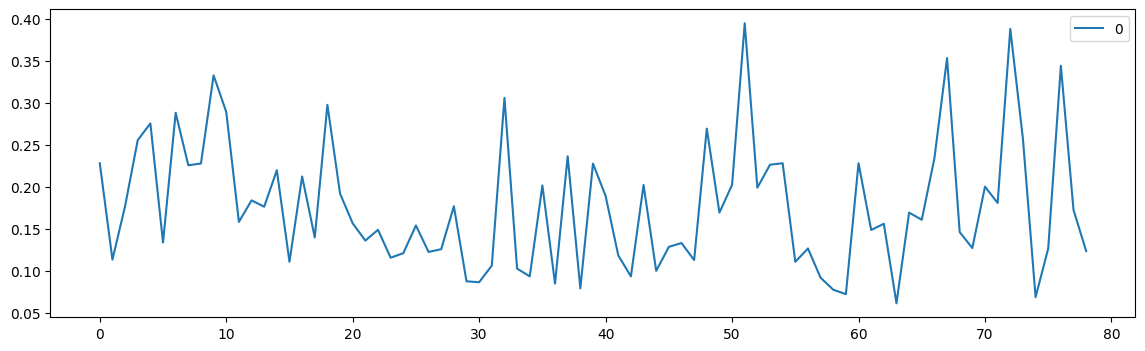

In [17]:
diff_threshold = []
for i in range(len(diff_list)):
    diff_threshold.append(diff_list.iloc[i][np.argmax(diff_list.iloc[i])])
pd.DataFrame(diff_threshold).plot()

In [18]:
import serial
import re

# 시리얼 포트 설정
port = '/dev/ttyACM0'  # 사용할 COM 포트 번호
baudrate = 460800  # 장치와 일치하는 전송 속도
timeout = 2  # 타임아웃 설정 (2초)

def find_different(data):
    if len(background) == 0:
        background.append(data)
    elif len(background) < 20:
        background.append(data)
        now_background = np.median(background, axis=0)
        subtrack = np.abs(data - now_background)
        return subtrack
    else:
        background.pop(0)
        background.append(data)
        now_background = np.median(background, axis=0)
        subtrack = np.abs(data - now_background)
        return subtrack
    
def regularize(data):
    """
    데이터 정규화 함수
    """
    return (data - data.min()) / (data.max() - data.min())

def same_peak_flatten(data):
    peak = np.argmax(data)
    return data.iloc[peak-10:peak+150].reset_index(drop=True, inplace=False)

def clean_data(raw_data):
    """
    수신된 원시 데이터를 정제하여 숫자 값 리스트로 반환합니다.
    """
    cleaned_data = []
    for item in raw_data:
        # 문자열 내의 숫자 패턴 찾기
        match = re.search(r'\d+\.\d+|\d+', item)
        if match:
            cleaned_data.append(float(match.group()))
    return cleaned_data

try:
    # 시리얼 포트 열기
    ser = serial.Serial(port, baudrate, timeout=timeout)

    print(f"Connected to {port} at {baudrate} baudrate.")
    data_buffer = ""  # 수신 데이터를 임시 저장할 버퍼
    temp_list = []  # 임시 리스트
    final_list = []  # 최종 cir 리스트
    final_distance = []  # 최종 거리값 리스트
    diff_list = []  # 차이값 리스트
    background = []
    now_background = []

    while True:
        # 시리얼 포트로부터 데이터 읽기
        if ser.in_waiting > 0:  # 읽을 데이터가 있는 경우
            data = ser.read(ser.in_waiting).decode('utf-8', errors='ignore')  # 모든 가용 데이터를 읽어옴
            data_buffer += data  # 수신 데이터를 버퍼에 추가

            # 버퍼 내의 데이터에서 완성된 부분을 처리
            if ',' in data_buffer:
                # 데이터를 콤마를 기준으로 분할
                split_data = data_buffer.split(',')
                # 마지막 요소는 아직 완성되지 않은 데이터일 수 있으므로 버퍼에 남김
                data_buffer = split_data[-1]
                # 완성된 데이터들만 임시 리스트에 추가
                temp_list.extend([value.strip() for value in split_data[:-1]])

            # "DIST" 문자열을 만났는지 확인
            if "D" in data_buffer:
                # "DIST" 문자열을 만나면 임시 리스트를 최종 리스트에 추가
                cleaned_temp_list = clean_data(temp_list)  # 데이터 정제
                if len(cleaned_temp_list) % 992 == 0:
                    for i in range(0, len(cleaned_temp_list), 992):
                        final_list.append(cleaned_temp_list[i+1:i + 992])
                        final_distance.append(cleaned_temp_list[i])
                        clean_temp_list_df = pd.DataFrame(cleaned_temp_list[i+1:i+992])
                        same_peak_data = same_peak_flatten(clean_temp_list_df)
                        regular_data = regularize(same_peak_data)
                        diff = find_different(regular_data)
                        if diff is not None:
                            diff_list.append(diff.values.flatten())
                            print(f"Distance: {final_distance[-1]:.2f} | Peak: {np.argmax(diff) - 10:3d} | Maximum Difference: {diff.iloc[np.argmax(diff)].values[0]:5.3f}")

                else:
                    if len(cleaned_temp_list) > 992:
                        for i in range(0, len(cleaned_temp_list) - (len(cleaned_temp_list) % 992), 992):
                            final_list.append(cleaned_temp_list[i+1:i+992])
                            final_distance.append(cleaned_temp_list[i])
                            clean_temp_list_df = pd.DataFrame(cleaned_temp_list[i+1:i+992])
                            same_peak_data = same_peak_flatten(clean_temp_list_df)
                            regular_data = regularize(same_peak_data)
                            diff = find_different(regular_data)
                            if diff is not None:
                                diff_list.append(diff.values.flatten())
                                print(f"Distance: {final_distance[-1]:.2f} | Peak: {np.argmax(diff) - 10:3d} | Maximum Difference: {diff.iloc[np.argmax(diff)].values[0]:5.0f}")

                    # 임시 리스트 초기화
                temp_list = []

except serial.SerialException as e:
    print(f"Error opening or using serial port: {e}")

except KeyboardInterrupt:
    print("\nExiting program.")

finally:
    final_list = pd.DataFrame(final_list)
    final_distance = pd.DataFrame(final_distance)
    diff_list = pd.DataFrame(diff_list)
    if 'ser' in locals() and ser.is_open:
        ser.close()  # 프로그램 종료 시 시리얼 포트 닫기
        print("Serial port closed.")

Connected to /dev/ttyACM0 at 460800 baudrate.
Distance: 0.43 | Peak:   1 | Maximum Difference: 0.106
Distance: 0.43 | Peak:   8 | Maximum Difference: 0.016
Distance: 0.45 | Peak:   1 | Maximum Difference: 0.085
Distance: 0.45 | Peak:   1 | Maximum Difference: 0.323
Distance: 0.45 | Peak:   2 | Maximum Difference: 0.052
Distance: 0.45 | Peak:   2 | Maximum Difference: 0.027
Distance: 0.44 | Peak:   1 | Maximum Difference: 0.087
Distance: 0.41 | Peak:   1 | Maximum Difference: 0.202
Distance: 0.47 | Peak:  -1 | Maximum Difference: 0.172
Distance: 0.45 | Peak:   1 | Maximum Difference: 0.220
Distance: 0.44 | Peak:   1 | Maximum Difference: 0.277
Distance: 0.45 | Peak:   1 | Maximum Difference: 0.133
Distance: 0.44 | Peak:   1 | Maximum Difference: 0.183
Distance: 0.42 | Peak:  -2 | Maximum Difference: 0.272
Distance: 0.40 | Peak:   1 | Maximum Difference: 0.310
Distance: 0.43 | Peak:  -2 | Maximum Difference: 0.305
Distance: 0.44 | Peak:   2 | Maximum Difference: 0.113
Distance: 0.41 | Pe

(67, 991)
(67, 1)


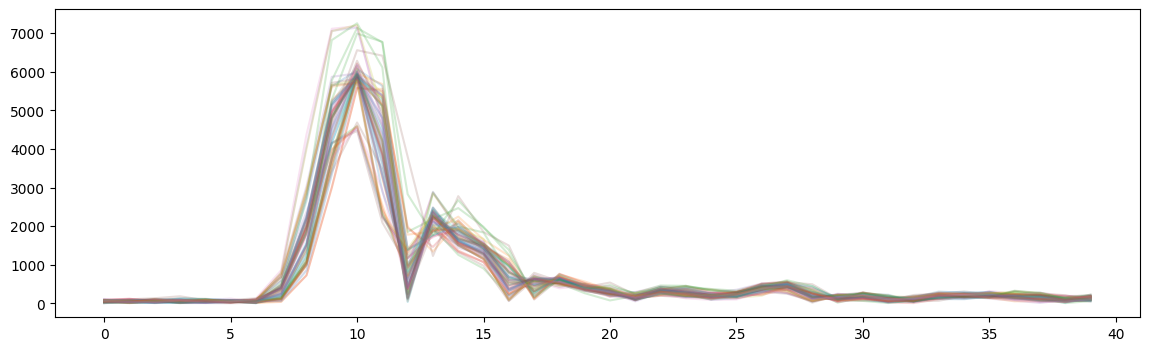

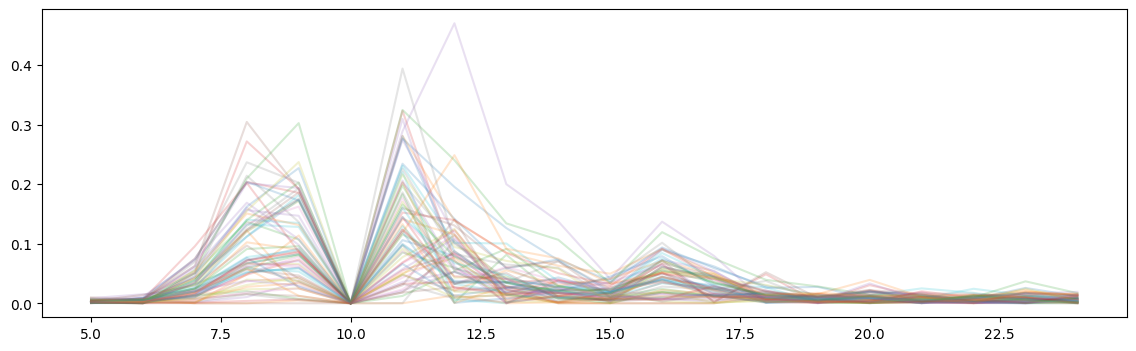

6


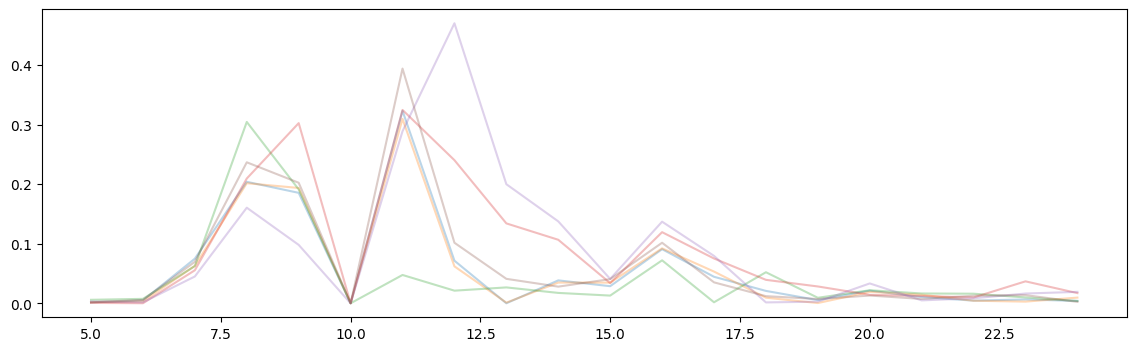

In [19]:
print(final_list.shape)
print(final_distance.shape)
same_final = same_peak(final_list)
same_final.shape

for i in range(len(same_final)):
    same_final.loc[i][:40].plot(alpha=0.2)
plt.show()
for i in range(len(diff_list)):
    diff_list.loc[i][5:25].plot(alpha=0.2)
plt.show()

count = 0
for i in range(len(diff_list)):
    if diff_list.iloc[i][np.argmax(diff_list.iloc[i])] > 0.3:   # threshold가 2000은 되어야 변화가 일어난 것일듯?
        diff_list.iloc[i][5:25].plot(alpha=0.3)
        count += 1
print(count)

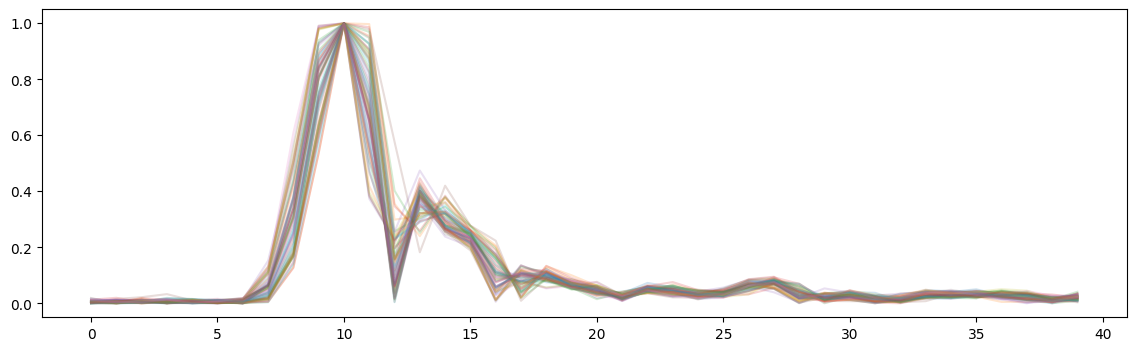

In [20]:
# final_list 정규화
for i in range(len(same_final)):
    regularize(same_final.loc[i][:40]).plot(alpha=0.2)

<Axes: >

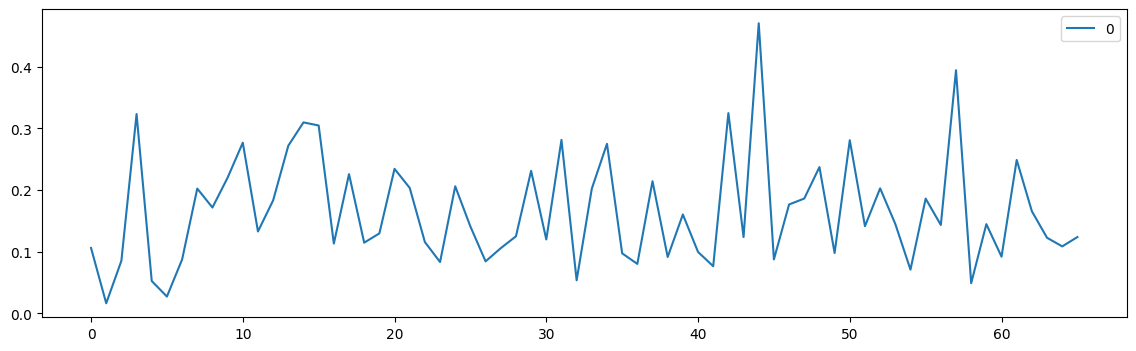

In [21]:
diff_threshold = []
for i in range(len(diff_list)):
    diff_threshold.append(diff_list.iloc[i][np.argmax(diff_list.iloc[i])])
pd.DataFrame(diff_threshold).plot()